In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("machine.csv")
df.head()


,adviser,32/60,125,256,6000,256.1,16,128,198,199
0,amdahl,470v/7,29,8000,32000,32,8,32,269,253
1,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
2,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
3,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
4,amdahl,470v/b,26,8000,32000,64,8,32,318,290


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   adviser  208 non-null    object
 1   32/60    208 non-null    object
 2   125      208 non-null    int64 
 3   256      208 non-null    int64 
 4   6000     208 non-null    int64 
 5   256.1    208 non-null    int64 
 6   16       208 non-null    int64 
 7   128      208 non-null    int64 
 8   198      208 non-null    int64 
 9   199      208 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.4+ KB


In [27]:
df.isnull().sum()

adviser    0
32/60      0
125        0
256        0
6000       0
256.1      0
16         0
128        0
198        0
199        0
dtype: int64

7. Attribute Information:
   1. vendor name: 30 
      (adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, 
       dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson, 
       microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry, 
       sratus, wang)
   2. Model Name: many unique symbols
   3. MYCT: machine cycle time in nanoseconds (integer)
   4. MMIN: minimum main memory in kilobytes (integer)
   5. MMAX: maximum main memory in kilobytes (integer)
   6. CACH: cache memory in kilobytes (integer)
   7. CHMIN: minimum channels in units (integer)
   8. CHMAX: maximum channels in units (integer)
   9. PRP: published relative performance (integer)
  10. ERP: estimated relative performance from the original article (integer)


In [7]:
df1 = df.copy()

# column adlarini index edirik
df1.columns = df1.iloc[0]
# column adlarini deyishirik
new_column = ['Vendor_Name','Model_Name','MCYT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX','PRP','ERP']
df1.columns = new_column
print(df1)


    Vendor_Name     Model_Name  MCYT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  \
0        amdahl         470v/7    29  8000  32000    32      8     32  269   
1        amdahl        470v/7a    29  8000  32000    32      8     32  220   
2        amdahl        470v/7b    29  8000  32000    32      8     32  172   
3        amdahl        470v/7c    29  8000  16000    32      8     16  132   
4        amdahl         470v/b    26  8000  32000    64      8     32  318   
..          ...            ...   ...   ...    ...   ...    ...    ...  ...   
203      sperry           80/8   124  1000   8000     0      1      8   42   
204      sperry  90/80-model-3    98  1000   8000    32      2      8   46   
205      sratus             32   125  2000   8000     0      2     14   52   
206        wang         vs-100   480   512   8000    32      0      0   67   
207        wang          vs-90   480  1000   4000     0      0      0   45   

     ERP  
0    253  
1    253  
2    253  
3    132  
4    290

ERP sizin targetinizdir. Meqsed ise lr tetbiq edib VIF-i, cooks' distance-i en sonda ise lr vasitesile prediction tapmaqdir.

In [8]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Vendor_Name  208 non-null    object
 1   Model_Name   208 non-null    object
 2   MCYT         208 non-null    int64 
 3   MMIN         208 non-null    int64 
 4   MMAX         208 non-null    int64 
 5   CACH         208 non-null    int64 
 6   CHMIN        208 non-null    int64 
 7   CHMAX        208 non-null    int64 
 8   PRP          208 non-null    int64 
 9   ERP          208 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.4+ KB


In [9]:
df1.describe()

,MCYT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,204.201923,2880.538462,11824.019231,24.096154,4.644231,17.740385,105.177885,98.850962
std,260.833016,3883.839300,11747.916663,37.417999,6.787198,24.913375,161.090223,154.974961
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,49.500000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,111.500000,99.500000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000,1238.000000


In [10]:
df_columns = df1.columns
int_cols = df1.select_dtypes(include='int64').columns ## int columnlar
scaler = MinMaxScaler()
df1[int_cols] = scaler.fit_transform(df1[int_cols])
# MinMaxScaler esasinda yaradilmish datadan cedvel qurulmasi
df_columns = df1.columns
df1 = pd.DataFrame(df1)
df1.columns = df_columns

df1.head()

,Vendor_Name,Model_Name,MCYT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,amdahl,470v/7,0.008092,0.248497,0.499499,0.125,0.153846,0.181818,0.229895,0.194603
1,amdahl,470v/7a,0.008092,0.248497,0.499499,0.125,0.153846,0.181818,0.187063,0.194603
2,amdahl,470v/7b,0.008092,0.248497,0.499499,0.125,0.153846,0.181818,0.145105,0.194603
3,amdahl,470v/7c,0.008092,0.248497,0.249249,0.125,0.153846,0.090909,0.110140,0.095666
4,amdahl,470v/b,0.006069,0.248497,0.499499,0.250,0.153846,0.181818,0.272727,0.224857


In [11]:
df1.describe()

,MCYT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.126232,0.088193,0.183934,0.094126,0.089312,0.100798,0.086694,0.068562
std,0.175882,0.121613,0.183745,0.146164,0.130523,0.141553,0.140813,0.126717
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.022252,0.022044,0.061562,0.000000,0.019231,0.028409,0.018357,0.010630
50%,0.062711,0.060621,0.124124,0.031250,0.038462,0.045455,0.038024,0.024530
75%,0.140256,0.123246,0.249249,0.125000,0.115385,0.136364,0.092220,0.069092
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
df1.corr()

,MCYT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
MCYT,1.000000,-0.337071,-0.379592,-0.340414,-0.300734,-0.255629,-0.306571,-0.287806
MMIN,-0.337071,1.000000,0.757827,0.602788,0.526665,0.293877,0.798310,0.823113
MMAX,-0.379592,0.757827,1.000000,0.600680,0.568594,0.562388,0.865576,0.904180
CACH,-0.340414,0.602788,0.600680,1.000000,0.588128,0.423550,0.704642,0.687428
CHMIN,-0.300734,0.526665,0.568594,0.588128,1.000000,0.541762,0.608841,0.610094
CHMAX,-0.255629,0.293877,0.562388,0.423550,0.541762,1.000000,0.621309,0.606281
PRP,-0.306571,0.798310,0.865576,0.704642,0.608841,0.621309,1.000000,0.966423
ERP,-0.287806,0.823113,0.904180,0.687428,0.610094,0.606281,0.966423,1.000000


<Axes: xlabel='PRP', ylabel='ERP'>

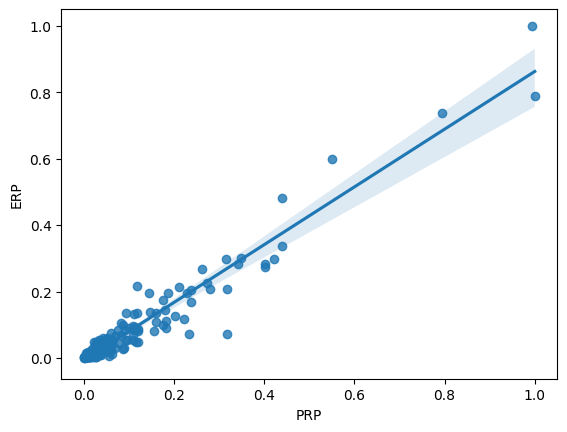

In [13]:
sns.regplot(x="PRP", y="ERP", data=df1, fit_reg=True)

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vendor_Name  208 non-null    object 
 1   Model_Name   208 non-null    object 
 2   MCYT         208 non-null    float64
 3   MMIN         208 non-null    float64
 4   MMAX         208 non-null    float64
 5   CACH         208 non-null    float64
 6   CHMIN        208 non-null    float64
 7   CHMAX        208 non-null    float64
 8   PRP          208 non-null    float64
 9   ERP          208 non-null    float64
dtypes: float64(8), object(2)
memory usage: 16.4+ KB


In [15]:
X = df1.drop(['ERP','Vendor_Name','Model_Name'], axis=1)
y = df1['ERP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


X_train shape: (145, 7)
X_test shape: (63, 7)
y_train shape: (145,)
y_test shape: (63,)


In [16]:
lr = LinearRegression()

# Modeli telim datalarina uygunlasdirirq
lr.fit(X_train, y_train)

# Test datalarina uygun Proqnozlarin verilmesi
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)

print('Mean squared error:', mse)
print('R2 Score:', r2)

Mean squared error: 0.0012596420047416767
R2 Score: 0.9181646196082185


Xətti reqressiya kontekstində "cosntant" termini reqressiya tənliyindəki ara termini ifadə edir. Reqressiya tənliyi bu formulaya malikdir:

y = b0 + b1x1 + b2x2 + ... + bn*xn

burada y-asılı dəyişən, x1, x2,..., xn müstəqil dəyişənlərdir, b0 ara müddətdir('intercept term') və b1, b2,..., BN-müstəqil dəyişənlərin əmsallarıdir.

Ara müddəti və ya sabit('constant'), bütün müstəqil dəyişənlərin sıfır olduğu y dəyəridir. Başqa sözlə, müstəqil dəyişənlərin təsiri olmadıqda y dəyərini təmsil edir. Sabit vacibdir, çünki reqressiya xəttinin məlumatlara uyğun olaraq "yuxarıya doğru sürüşməsinə" və ya "aşağıya doğru sürüşməsinə" imkan verir. Daimi bir üzv sabit, reqressiya xətti həmişə mənşəyindən keçəcəkdir ki, bu da bir çox real dünya məlumat dəstləri üçün uyğun olmaya bilər.

Scikit-learn və ya statsmodels kimi bir paketdən istifadə edərək xətti reqressiya modelini uyğunlaşdırarkən, ümumiyyətlə modelə daimi bir üzv daxil etmək və ya istisna etmək seçiminiz var. Məsələn, scikit-learn-da, başqa cür göstərməsəniz, sabit müddət standart olaraq aktivdir. Statsmodels-də, modelə daxil edilməsini istəyirsinizsə, add_constant metodundan istifadə edərək daimi bir sabit əlavə etməlisiniz.

In [17]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Xususiyyet matrisine sabit term elave edirik
X_train = sm.add_constant(X_train)

# Her bir deyer ucun Variyansin Inflyasiya Faktorunu elave edirik
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
# print the VIFs
print(vif)


   VIF Factor features
0    5.333239    const
1    1.309560     MCYT
2    4.747371     MMIN
3    4.668555     MMAX
4    2.827582     CACH
5    2.235651    CHMIN
6    2.045256    CHMAX
7    9.071103      PRP


Bizim neticelerde vif dəyərləri hər proqnozlaşdırıcı dəyişəndə çoxölçülüyün dərəcəsini göstərir. Const işarəsi proqnozlaşdırıcı dəyişən deyil, xətti reqressiya modelindəki ara müddətdir("cosntant"). Əsas qayda budur ki, 5-dən çox olan VIF dəyəri yüksək çoxölçülüyü göstərir, 10-dan çox olan VIF dəyəri isə çox yüksək hesab olunur.

VIF nəticələrinizə baxdıqda, MCYT, MMIN və MMAX-ın vıf dəyərləri 4-dən çox olduğu görünür və bu dəyişənlərin modeldəki bir və ya daha çox digər proqnozlaşdırıcı dəyişənlərlə çox əlaqəli olduğunu göstərir. Bunun əksinə olaraq, CACH, CHMİN və CHMAX digər proqnozlaşdırıcılarla orta dərəcədə korrelyasiya səviyyəsinə malikdir, PRP isə çoxölçülükdən təsirlənə biləcəyini göstərən çox yüksək vıf dəyərinə malikdir.

In [18]:
X = df1.drop(['ERP','Vendor_Name','Model_Name','MMAX','PRP'], axis=1)
y = df1['ERP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


X_train shape: (145, 5)
X_test shape: (63, 5)
y_train shape: (145,)
y_test shape: (63,)


VIF nəticələrinizə baxdıqda, MMIN və MMAX-ın vıf dəyərlərinin multicolinear olduğu görünür[4.747371     MMIN, 4.668555     MMA ] . Buna gorede yeni modelde sadece [MMIN] daxil edirik eyni zamanda PRP vif deyeri cox olduqundan ondan istifade etmirik

In [19]:
lr = LinearRegression()

# Modeli Telim datalarina uygunlasdirriq
lr.fit(X_train, y_train)

# Test datasina gore Proqnozlar veririk
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)

print('Mean squared error:', mse)
print('R2 Score:', r2)

Mean squared error: 0.0030586656010601395
R2 Score: 0.8012871418928702


In [20]:
import statsmodels.api as sm

X = df1[['MCYT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']]
y = df1['ERP']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

influence = model.get_influence()
(c, _) = influence.cooks_distance
threshold = 4 / (len(df1)-5-1)

# tesir eden observationlar
org_outliers = np.where(c > threshold)[0]
print("Original outliers:", org_outliers)


Original outliers: [  7   8  18  81  89  90  94  95 136 155 196 197 198]


məsafə üçün 4/(n-p-1), reqressiya analizində təsirli nöqtələri təyin etmək üçün istifadə olunur. 4-ə bölünmə, Kukun məsafəsini normallaşdırmaq üçün edilir ki, f-paylanmasına bənzər bir miqyas alsın.

Ümumiyyətlə, Kukun məsafəsi, ı-ci müşahidənin heç bir təsiri olmadığı sıfır fərziyyəsi ilə P və n-p-1 sərbəstlik dərəcələri ilə F paylanmasına uyğundur. 4/(n-p-1) dəyəri P və n-p-1 sərbəstlik dərəcələri ilə F paylanmasının 95-ci faizinə uyğundur. Beləliklə, Cook məsafəsi bu həddi aşan müşahidələrin reqressiya analizinə böyük təsir göstərdiyi düşünülür.
Cook məsafəsinin 4 - ə bölünməsi, Cook məsafəsinin dəyərlərini F paylanması ilə müqayisə etməyi asanlaşdıran bir konvensiyadır.
Cook məsafəsi düsturunda p, reqressiya modelindəki proqnozlaşdırıcıların və ya müstəqil dəyişənlərin sayı, n isə məlumat dəstindəki müşahidələrin və ya məlumat nöqtələrinin sayıdır.

Başqa sözlə, p dizayn matrisindəki sütunların sayını təmsil edir X (Cosntant istisna olmaqla), n isə məlumat dəstindəki sətirlərin və ya müşahidələrin sayını təmsil edir.

In [21]:
def outlier_detection(df1, col, outliers):
    fqr = df1[col].quantile(0.25)
    tqr = df1[col].quantile(0.75)
    iqr = tqr-fqr
    df = df1[(df1[col]<(fqr-1.5*iqr))|(df1[col]>(tqr+1.5*iqr))]
    # Outlier
    df = df[~df.index.isin(outliers)]
    return df[col]

In [22]:
outlier_detection(df1,'ERP',org_outliers)

0      0.194603
1      0.194603
2      0.194603
4      0.224857
5      0.299264
6      0.299264
96     0.167621
150    0.205233
151    0.208504
152    0.336059
154    0.206051
167    0.217498
190    0.212592
191    0.300082
194    0.173344
195    0.266558
Name: ERP, dtype: float64

In [23]:
df1['ERP'] = outlier_detection(df1,'ERP',org_outliers)
df1['ERP'].isnull().sum()

192

In [24]:
df1.dropna(subset=['ERP'], inplace=True)
df1['ERP'].isnull().sum()

0

Son defe yekun modeli qururuq bu halda ERP deyerlerimiz daha deqiqdir

In [25]:
X = df1.drop(['ERP','Vendor_Name','Model_Name','MMAX','PRP'], axis=1)
y = df1['ERP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


X_train shape: (11, 5)
X_test shape: (5, 5)
y_train shape: (11,)
y_test shape: (5,)


In [26]:
lr = LinearRegression()

# Modeli Telim datalarina uygunlasdirirq
lr.fit(X_train, y_train)

# Test datalari uzerinden proqnozlar veririk
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)

print('Mean squared error:', mse)
print('R2 Score:', r2)

Mean squared error: 0.0004044646370418762
R2 Score: 0.8686493679440508
